<a href="https://colab.research.google.com/github/HmzaMalik/sort-google-scholar/blob/master/gscholar_scrape_on_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Scrape Data from Google Scholar to CSV file.

### Import Libraries and Define Functions

#### The following cell will import the libraries and define the functions that will be used in this Colab notebook.
\
\
P.S. If it displays a warning about server connectivity, reset the connection of your Colab notebook.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import unicodedata
import os

# %%
def scrape_data(keyword, number_of_results, start_year, end_year, review_articles=0):
    data = []
    headers=["Title", "Abstract", "Citations", "Link", "AJYP"]
    for page in range(0, number_of_results, 10):
        if start_year == "" and end_year == "":
            url = f"https://scholar.google.com/scholar?start={page}&q={keyword}&hl=en&as_sdt=0,5&as_rr={review_articles}"
        else:
            url = f"https://scholar.google.com/scholar?start={page}&q={keyword}&hl=en&as_sdt=0,5&as_ylo={start_year}&as_yhi={end_year}&as_rr={review_articles}"
        response = requests.get(url)
        soup = BeautifulSoup(response.text, "html.parser")
        main_content = soup.find(id="gs_res_ccl")
        if main_content:
            articles = main_content.find_all("div", class_="gs_ri")
            for article in articles:
                title = article.find("h3", class_="gs_rt").text
                abstract = article.find("div", class_="gs_rs").text
                ajyp = article.find("div", class_="gs_a").text
                link_element = article.find("h3", class_="gs_rt").find("a")
                link = link_element["href"] if link_element else ""
                
                # Get the citation count
                citation_count = 0
                citation_count_section = article.find("div", class_="gs_fl")
                if citation_count_section:
                    for citation_link in citation_count_section.find_all("a"):
                            if citation_link.text.startswith("Cited by"):
                                citation_count = citation_link.text.replace("Cited by", "").strip()
                                break
                try:
                    title = unicodedata.normalize('NFKD', title).encode('ascii', 'ignore').decode('utf-8')
                    abstract = unicodedata.normalize('NFKD', abstract).encode('ascii', 'ignore').decode('utf-8')
                    ajyp = unicodedata.normalize('NFKD', ajyp).encode('ascii', 'ignore').decode('utf-8')
                    data.append([title, abstract, citation_count, link, ajyp])
                except:
                    data.append([title, abstract, citation_count, link, ajyp])
    df = pd.DataFrame(data, columns=headers)
    try:
        df["Citations"] = pd.to_numeric(df["Citations"], errors="coerce").astype("Int64") 
        try:
            df["Citations"] = df["Citations"].astype("Int64")
        except:
            pass       
    except:
            pass
    df.index.name = 'Rank'
    return df

def extract_info(df, column_name):
    result=[]
    year_regex = r"\b\d{4}\b"
    for text in df[column_name]:
        parts = text.split("- ")
        if len(parts) == 3:
            author = parts[0].strip()
            publisher = parts[2].strip()

            try:
                year = re.findall(year_regex, parts[1])[-1]
                journal = parts[1][::-1].replace(year[::-1], ""[::-1],1)[::-1].strip().rstrip(",")
            except IndexError:
                year = ""
                journal = parts[1]

        if len(parts) == 2:
            author = parts[0].strip()
            try:
                year = re.findall(year_regex, parts[1])[-1]
                journal = parts[1][::-1].replace(year[::-1], ""[::-1],1)[::-1].strip().rstrip(",")
                publisher = ""
            except IndexError:
                year = ""
                journal = ""
                publisher = parts[1]
        result.append({'Author': author, 'Journal': journal, 'Publisher': publisher, 'Year': (year)})
    df2 = pd.DataFrame(result)

    try:
        df2["Year"]=pd.to_numeric(df2["Year"], errors='coerce')
        try:
            df2["Year"]= df2["Year"].astype('Int64')
        except:
            pass       
    except:
            pass    
    
    df = pd.concat([df,df2],axis=1)

    try:
        df['Cit/Year']=(df['Citations']/(df['Year'].max() + 1 - df['Year'])).round(0).astype('Int64')
    except:
            pass
    
    df.index.name = 'Rank'
    return df


if requests.get("https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=test").status_code >= 400:
    print("\n\n\n\033[1m\033[31m!!! Warning !!! \n\n Current colab server is unable to connect with Google Scholar. Please disconnect and reconnect your Colab notebook, then run this cell again before proceeding further.\033[0m\n\n\n")

### Search for Research Papers

Enter the following information to search for research papers:

* Keyword/Search term:
* Number of results to return (default 50):
* Start year (if any):
* End year (if any):
* Only return review articles (1=True):

In [ ]:
kw= input("Enter keyword: ")
num_of_results = input("Enter number of results (or press enter for default value 50): ") or 50
if num_of_results != "":
    while True:
        try:
            num_of_results = int(num_of_results)
            break;
        except:
            num_of_results = input("invalid number of results. Please enter again: ")

start_year = input("Enter start year (if any): ")
if start_year != "":
    while True:
        try:
            start_year = int(start_year)
            break;
        except:
            start_year = input("invalid start year. Please enter again: ")

end_year = input("Enter end year (if any): ")
if end_year != "":
    while True:
        try:
            end_year = int(end_year)
            break;
        except:
            end_year = input("invalid end year. Please enter again: ")

review_articles = input("Enter 1 for review articles only: ") or '0'
if review_articles != "":
    while review_articles not in ("0", "1"):
        review_articles = input("invalid input. Please enter 0 (for default outcome) or 1 (for review articles only): ")
    review_articles = int(review_articles)

df = scrape_data(kw, number_of_results=num_of_results, start_year=start_year, end_year=end_year, review_articles=review_articles)

try:
    df = extract_info(df[["Title","Citations","Abstract","Link","AJYP"]],"AJYP")
except:
    pass

print(f'\n\n\nThis dataframe includes total of {df.shape[0]} rows and {df.shape[1]} columns.\n\nFollowing table is a preview of top 4 rows of the dataframe:\n')
df.head()

#### Run the following cell to get the Plot of "Publications Per Year".

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

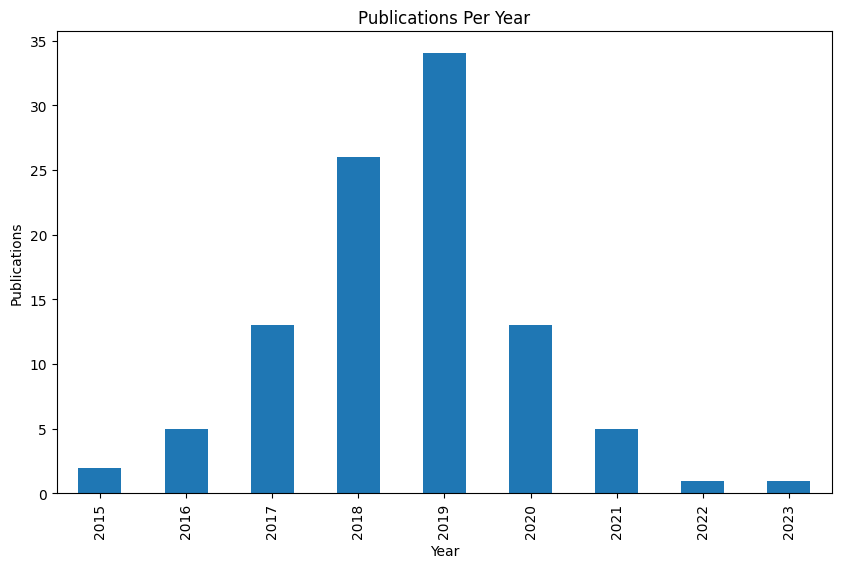

In [4]:
try:
    ax = df['Year'].value_counts().sort_index().plot(kind='bar', figsize=(10, 6))
    ax.set_xlabel('Year')
    ax.set_ylabel('Publications')
    ax.set_title('Publications Per Year')
    filename = 'publication_per_year.png'
    # Check if the file already exists
    while os.path.exists(filename):
        user_input = input(f"The file '{filename}' already exists. Enter 'y' to overwrite or enter a new filename: ")
        if user_input.lower() == 'y':
            break
        else:
            filename = user_input

    # Save the plot as an image file
    fig = ax.get_figure()
    fig.savefig(filename)
    try:
        from glob import glob
        from google.colab import files
        fn= sorted(glob("*.png"), key=os.path.getmtime, reverse=True)[0]
        files.download(fn)
    except:
        pass
except:
    pass

### Sort Dataframe by Preferred Column and Save Results

The following cell will sort the DataFrame by a preferred column and save the result to a CSV file. You can choose to sort by the following columns:

- "Title"
- "Author"
- "Year"
- "Cit/Year"
- "Journal" or "Publisher"

The default is sorted by the total number of citations ("Citations").

In [7]:
try:
    df = df.sort_values(by=input('Sort by preferred columns i.e.(Title, Author, Year, Cit/Year, Journal or Publisher)\n Dafault is by "Citations"\n'), ascending=False)
except Exception as e:
    print('Column name to be sorted not found. Sorting by the number of citations...')
    df = df.sort_values(by='Citations', ascending=False)

columns=["Author","Title","Citations","Year", 'Cit/Year',"Abstract","Link","Journal","Publisher","AJYP"]

try:
    df[columns].to_csv(f"{kw}_gs.csv")
except:
    try:
        df[columns].to_csv("file_gs.csv")
    except:
        try:
            df.to_csv(f"{kw}_gs.csv")
        except:
            df.to_csv("file_gs.csv")

try:
    from glob import glob
    from google.colab import files
    fn= sorted(glob("*.csv"), key=os.path.getmtime, reverse=True)[0]
    files.download(fn)
except:
    pass


Sort by preferred columns i.e.(Title, Author, Year, Cit/Year, Journal or Publisher)
 Dafault is by "Citations"
Cit/Year


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>